In [1]:
import sys
sys.path.insert(0, "/home/kohei3/anaconda3/envs/tensorflow/lib/python3.6/site-packages/")
import os
import random

import numpy as np
import pandas as pd
import feather
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(action="ignore",category=DeprecationWarning)
warnings.filterwarnings(action="ignore",category=FutureWarning)

import matplotlib.pyplot as plt
import tensorflow as tf
import math
import gc
import copy
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import keras
from keras.layers import Dense, Input, Activation
from keras.layers import BatchNormalization,Add,Dropout
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras import callbacks
from keras import backend as K

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5106827182071126523
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7896396596
locality {
  bus_id: 1
  links {
  }
}
incarnation: 16482771610563754234
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [5]:
train = pd.read_csv("../data/input/train.csv")
test = pd.read_csv("../data/input/test.csv")
target = train["scalar_coupling_constant"].values

In [6]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [7]:
features = [
        "Atom",
        #"AtomPosition",
        #"AtomDistance",
        #"CouplingType",
        #"AtomEnvironment",
        #"AtomNeighbors",
        #"BruteForce",
        #"DistanceFromClosest",
        #"ElectroNegFromClosest",
        "ACSF",
        #"MullikenChargePred",
        #"OpenBabelBasic",
        #"CosineDistance",
        #"PotentialPred", 
        "DisIsAllYouNeed"]

In [8]:
X_train = pd.concat([feather.read_dataframe("../features/" + feature + "_train.feather") for feature in features], axis=1)
X_test = pd.concat([feather.read_dataframe("../features/" + feature + "_test.feather") for feature in features], axis=1)

In [9]:
X_train.shape, X_test.shape

((4658147, 290), (2505542, 290))

In [10]:
X_train.head()

,atom_0,atom_1,acsf_0_a0,acsf_1_a0,acsf_2_a0,acsf_3_a0,acsf_4_a0,acsf_5_a0,acsf_6_a0,acsf_7_a0,...,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
0,H,C,2.770731,2.643446,2.757731,2.769428,5.248240e-08,0.468098,2.319362,0.970867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,H,H,2.770731,2.643446,2.757731,2.769428,5.248240e-08,0.468098,2.319362,0.970867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,H,H,2.770731,2.643446,2.757731,2.769428,5.248240e-08,0.468098,2.319362,0.970867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,H,H,2.770731,2.643446,2.757731,2.769428,5.248240e-08,0.468098,2.319362,0.970867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,H,C,2.770731,2.643447,2.757731,2.769428,5.248280e-08,0.468098,2.319362,0.970867,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# keep nan as is
#coupling_types = X_train['type']
categorical_cols = list(X_train.columns[X_train.dtypes == object])


for col in categorical_cols:    
    print(f'Starting {col}')
    uniques = list(X_train[col].unique())
    if None in uniques:
        uniques.remove(None)
    mapping = dict(zip(uniques, range(1, len(uniques)+1)))
    X_train[col] = X_train[col].map(mapping)
    X_test[col] = X_test[col].map(mapping)

Starting atom_0
Starting atom_1


In [12]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 9524.41 MB
Memory usage after optimization is: 5019.86 MB
Decreased by 47.3%
Memory usage of dataframe is 5123.03 MB
Memory usage after optimization is: 2700.10 MB
Decreased by 47.3%


In [13]:
X_train.columns.values

array(['atom_0', 'atom_1', 'acsf_0_a0', 'acsf_1_a0', 'acsf_2_a0',
       'acsf_3_a0', 'acsf_4_a0', 'acsf_5_a0', 'acsf_6_a0', 'acsf_7_a0',
       'acsf_8_a0', 'acsf_9_a0', 'acsf_10_a0', 'acsf_11_a0', 'acsf_12_a0',
       'acsf_13_a0', 'acsf_14_a0', 'acsf_15_a0', 'acsf_16_a0',
       'acsf_17_a0', 'acsf_18_a0', 'acsf_19_a0', 'acsf_20_a0',
       'acsf_21_a0', 'acsf_22_a0', 'acsf_23_a0', 'acsf_24_a0',
       'acsf_25_a0', 'acsf_26_a0', 'acsf_27_a0', 'acsf_28_a0',
       'acsf_29_a0', 'acsf_30_a0', 'acsf_31_a0', 'acsf_32_a0',
       'acsf_33_a0', 'acsf_34_a0', 'acsf_35_a0', 'acsf_36_a0',
       'acsf_37_a0', 'acsf_38_a0', 'acsf_39_a0', 'acsf_40_a0',
       'acsf_41_a0', 'acsf_42_a0', 'acsf_43_a0', 'acsf_44_a0',
       'acsf_45_a0', 'acsf_46_a0', 'acsf_47_a0', 'acsf_48_a0',
       'acsf_49_a0', 'acsf_50_a0', 'acsf_51_a0', 'acsf_52_a0',
       'acsf_53_a0', 'acsf_54_a0', 'acsf_55_a0', 'acsf_56_a0',
       'acsf_57_a0', 'acsf_58_a0', 'acsf_59_a0', 'acsf_60_a0',
       'acsf_61_a0', 'acsf_62_a

In [14]:
# Set up GPU preferences
#config = tf.ConfigProto( device_count = {'GPU': 2 , 'CPU': 1} ) 
#config.gpu_options.allow_growth = True
#config.gpu_options.per_process_gpu_memory_fraction = 0.6
#sess = tf.Session(config=config) 
#K.set_session(sess)
session_conf = tf.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)
#session_conf.gpu_options.per_process_gpu_memory_fraction = 0.33

K.clear_session()
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [15]:
def create_nn_model(input_shape):
    inp = Input(shape=(input_shape,))
    x = Dense(1024, activation="relu")(inp)
    x = BatchNormalization()(x)
    x = Dropout(0.1)(x)
    x = Dense(512, activation="relu")(x)
    x = BatchNormalization()(x)
    x = Dense(256, activation="relu")(x)
    x = BatchNormalization()(x)
    out = Dense(1, activation="linear")(x)  
    model = Model(inputs=inp, outputs=[out])
    return model

def plot_history(history, label):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Loss for %s' % label)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    _= plt.legend(['Train','Validation'], loc='upper left')
    plt.show()

In [16]:
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder

mol_types=train["type"].unique()
cv_score=[]
cv_score_total=0
epoch_n = 2000
verbose = 1
batch_size = 1024
    
# Set to True if we want to train from scratch.  False will reuse saved models as a starting point.
retrain =True

start_time=datetime.now()
test_prediction=np.zeros(len(test))

#del train, test
#gc.collect()

cols = list(X_train.columns.values)

oh_cols = ['atom_0', 'atom_1', 'atom_2', 'atom_3', 'atom_4', 'atom_5', 
           'atom_6', 'atom_7', 'atom_8','atom_9']
           #'tertiary_atom_0', 'tertiary_atom_1', 'tertiary_atom_2', 'tertiary_atom_3',
         # 'tertiary_atom_4', 'tertiary_atom_5', 'tertiary_atom_6', 'tertiary_atom_7',
         # 'tertiary_atom_8', 'tertiary_atom_9', 'bond_atom']

continuous_cols = [col for col in cols if col not in oh_cols]


class FeatureTransformer:
    def transform(self, dataset, ohe_features=[], continuous_features=[]):
        ohe_df = OneHotEncoder().fit_transform(dataset.loc[:, ohe_features]).toarray()
        skews = dataset.loc[:, continuous_features].skew().to_dict()
        for column, skew in skews.items():
            if skew > 1:
                dataset[column] = np.log1p(dataset[column])
        return np.concatenate([StandardScaler().fit_transform(dataset.loc[:, continuous_features]), ohe_df], axis=1)


In [17]:
X_train.replace([np.inf, -np.inf], np.nan)
X_test.replace([np.inf, -np.inf], np.nan)

for col in X_train.columns:
    try:
        X_train[col].fillna(0, inplace=True)
    except:
        X_train[col] = X_train[col].cat.add_categories([0])
        X_train[col].fillna(0, inplace=True)
    
for col in X_test.columns:
    try:
        X_test[col].fillna(0, inplace=True)
    except:
        X_test[col] = X_test[col].cat.add_categories([0])
        X_test[col].fillna(0, inplace=True)  

In [18]:
train_type = train['type'].values
test_type = test['type'].values
molecule_name = train['molecule_name'].values

Training 1JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 567440 samples, validate on 141976 samples
Epoch 1/2000
567440/567440 [==============================] - 7s 13us/step - loss: 44.3702 - val_loss: 2.8876
Epoch 2/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.8429 - val_loss: 1.6080
Epoch 3/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.5910 - val_loss: 1.5128
Epoch 4/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.4797 - val_loss: 1.3617
Epoch 5/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.4148 - val_loss: 1.2535
Epoch 6/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.3645 - val_loss: 1.2485
Epoch 7/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.3085 - val_loss: 1.2413
Epoch 8/2000
567440/567440 [==============================] - 6s 11us/step - loss: 1.2889 - val_loss: 1

567440/567440 [==============================] - 6s 11us/step - loss: 0.8706 - val_loss: 0.7249
Epoch 75/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8526 - val_loss: 0.7392
Epoch 76/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8612 - val_loss: 0.7474
Epoch 77/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8742 - val_loss: 0.7764
Epoch 78/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8462 - val_loss: 0.7589
Epoch 79/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8605 - val_loss: 0.7547
Epoch 80/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8516 - val_loss: 0.8753
Epoch 81/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8473 - val_loss: 0.8421
Epoch 82/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.8527 - val_loss: 0.7963
Epoch 83/2000
567440/567

567440/567440 [==============================] - 6s 11us/step - loss: 0.7732 - val_loss: 0.7398
Epoch 149/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7729 - val_loss: 0.6688
Epoch 150/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7949 - val_loss: 0.7021
Epoch 151/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7739 - val_loss: 0.6952
Epoch 152/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7790 - val_loss: 0.7569
Epoch 153/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7793 - val_loss: 0.6867
Epoch 154/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7930 - val_loss: 0.7695
Epoch 155/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7565 - val_loss: 0.6853
Epoch 156/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7601 - val_loss: 0.6795
Epoch 157/2000
5

Epoch 222/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7388 - val_loss: 0.8663
Epoch 223/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7573 - val_loss: 0.6715
Epoch 224/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7405 - val_loss: 0.6421
Epoch 225/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7419 - val_loss: 0.8095
Epoch 226/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7643 - val_loss: 0.6537
Epoch 227/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7594 - val_loss: 0.7639
Epoch 228/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7505 - val_loss: 0.6875
Epoch 229/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7324 - val_loss: 0.6453
Epoch 230/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7353 - val_loss: 0.6500
E

Epoch 296/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7286 - val_loss: 0.6154
Epoch 297/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7311 - val_loss: 0.6175
Epoch 298/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7321 - val_loss: 0.6761
Epoch 299/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7352 - val_loss: 0.7081
Epoch 300/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7246 - val_loss: 0.6229
Epoch 301/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7255 - val_loss: 0.7210
Epoch 302/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7234 - val_loss: 0.6622
Epoch 303/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7181 - val_loss: 0.6478
Epoch 304/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7191 - val_loss: 0.6582
E

Epoch 370/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7035 - val_loss: 0.7239
Epoch 371/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6996 - val_loss: 0.6001
Epoch 372/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7099 - val_loss: 0.6194
Epoch 373/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7273 - val_loss: 0.6230
Epoch 374/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7384 - val_loss: 0.6216
Epoch 375/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6907 - val_loss: 0.6602
Epoch 376/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7122 - val_loss: 0.7327
Epoch 377/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7175 - val_loss: 0.6523
Epoch 378/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7105 - val_loss: 0.6110
E

Epoch 444/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6962 - val_loss: 0.6143
Epoch 445/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7014 - val_loss: 0.6122
Epoch 446/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6780 - val_loss: 0.5904
Epoch 447/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7073 - val_loss: 0.6071
Epoch 448/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6983 - val_loss: 0.6032
Epoch 449/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6887 - val_loss: 0.5958
Epoch 450/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6896 - val_loss: 0.6051
Epoch 451/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6988 - val_loss: 0.6182
Epoch 452/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7014 - val_loss: 0.6221
E

Epoch 518/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6973 - val_loss: 0.6073
Epoch 519/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7037 - val_loss: 0.5993
Epoch 520/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7063 - val_loss: 0.6735
Epoch 521/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6916 - val_loss: 0.5914
Epoch 522/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6736 - val_loss: 0.8558
Epoch 523/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.7020 - val_loss: 0.6787
Epoch 524/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6980 - val_loss: 0.5842
Epoch 525/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6979 - val_loss: 0.7304
Epoch 526/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6943 - val_loss: 0.5953
E

567440/567440 [==============================] - 6s 11us/step - loss: 0.6374 - val_loss: 0.6126
Epoch 592/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6541 - val_loss: 0.5759
Epoch 593/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6475 - val_loss: 0.7280
Epoch 594/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6700 - val_loss: 0.6313
Epoch 595/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6279 - val_loss: 0.6191
Epoch 596/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6541 - val_loss: 0.6590
Epoch 597/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6550 - val_loss: 0.5839
Epoch 598/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6453 - val_loss: 0.5737
Epoch 599/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6570 - val_loss: 0.5639

Epoch 00599: Re

567440/567440 [==============================] - 6s 11us/step - loss: 0.6054 - val_loss: 0.5788
Epoch 665/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6253 - val_loss: 0.6074
Epoch 666/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6233 - val_loss: 0.5575
Epoch 667/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6348 - val_loss: 0.5520
Epoch 668/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6304 - val_loss: 0.5617
Epoch 669/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5973 - val_loss: 0.5511
Epoch 670/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6136 - val_loss: 0.5517
Epoch 671/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6006 - val_loss: 0.5520
Epoch 672/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6271 - val_loss: 0.5868
Epoch 673/2000
5

567440/567440 [==============================] - 6s 11us/step - loss: 0.6107 - val_loss: 0.5501
Epoch 738/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6045 - val_loss: 0.5502
Epoch 739/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6023 - val_loss: 0.5600
Epoch 740/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6088 - val_loss: 0.5569
Epoch 741/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5995 - val_loss: 0.5427
Epoch 742/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5929 - val_loss: 0.5437
Epoch 743/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6118 - val_loss: 0.5421
Epoch 744/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6059 - val_loss: 0.5485
Epoch 745/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6024 - val_loss: 0.5511
Epoch 746/2000
5

567440/567440 [==============================] - 6s 11us/step - loss: 0.6083 - val_loss: 0.5415

Epoch 00810: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 811/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5807 - val_loss: 0.5403
Epoch 812/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6077 - val_loss: 0.5407
Epoch 813/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5830 - val_loss: 0.5441
Epoch 814/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5820 - val_loss: 0.5445
Epoch 815/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5858 - val_loss: 0.5414
Epoch 816/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6038 - val_loss: 0.5436
Epoch 817/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5957 - val_loss: 0.5431
Epoch 818/2000
567440/567440 [================

567440/567440 [==============================] - 6s 11us/step - loss: 0.5773 - val_loss: 0.5437
Epoch 883/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5885 - val_loss: 0.5428
Epoch 884/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5862 - val_loss: 0.5391
Epoch 885/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5889 - val_loss: 0.5400
Epoch 886/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5842 - val_loss: 0.5425
Epoch 887/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.6011 - val_loss: 0.5427
Epoch 888/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5928 - val_loss: 0.5396
Epoch 889/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5702 - val_loss: 0.5406
Epoch 890/2000
567440/567440 [==============================] - 6s 11us/step - loss: 0.5942 - val_loss: 0.5397
Epoch 891/2000
5

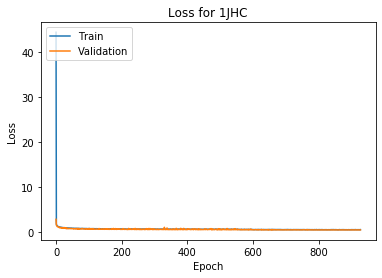

-0.619390266039144
Training 2JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 301863 samples, validate on 76173 samples
Epoch 1/2000
301863/301863 [==============================] - 4s 13us/step - loss: 3.4960 - val_loss: 0.7797
Epoch 2/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.5712 - val_loss: 0.5424
Epoch 3/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.4829 - val_loss: 0.4470
Epoch 4/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.4360 - val_loss: 0.4178
Epoch 5/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.4081 - val_loss: 0.3927
Epoch 6/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.3894 - val_loss: 0.4841
Epoch 7/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.3673 - val_loss: 0.3776
Epoch 8/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.3

301863/301863 [==============================] - 3s 11us/step - loss: 0.2079 - val_loss: 0.2064
Epoch 75/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2070 - val_loss: 0.2589
Epoch 76/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2061 - val_loss: 0.2775
Epoch 77/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2045 - val_loss: 0.2318
Epoch 78/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2098 - val_loss: 0.1805
Epoch 79/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2030 - val_loss: 0.2227
Epoch 80/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2045 - val_loss: 0.1738
Epoch 81/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1996 - val_loss: 0.1886
Epoch 82/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.2000 - val_loss: 0.1927
Epoch 83/2000
301863/301

301863/301863 [==============================] - 3s 11us/step - loss: 0.1626 - val_loss: 0.1504
Epoch 148/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1733 - val_loss: 0.1912
Epoch 149/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1647 - val_loss: 0.1946
Epoch 150/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1691 - val_loss: 0.1561
Epoch 151/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1651 - val_loss: 0.1712
Epoch 152/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1643 - val_loss: 0.2068
Epoch 153/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1645 - val_loss: 0.2781
Epoch 154/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1600 - val_loss: 0.1580
Epoch 155/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1643 - val_loss: 0.1536
Epoch 156/2000
3

301863/301863 [==============================] - 3s 11us/step - loss: 0.1487 - val_loss: 0.1298
Epoch 221/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1538 - val_loss: 0.1448
Epoch 222/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1432 - val_loss: 0.1490
Epoch 223/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1501 - val_loss: 0.1368
Epoch 224/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1463 - val_loss: 0.1351
Epoch 225/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1483 - val_loss: 0.1492
Epoch 226/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1510 - val_loss: 0.1407
Epoch 227/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1562 - val_loss: 0.1653
Epoch 228/2000
301863/301863 [==============================] - 3s 11us/step - loss: 0.1566 - val_loss: 0.1818
Epoch 229/2000
3

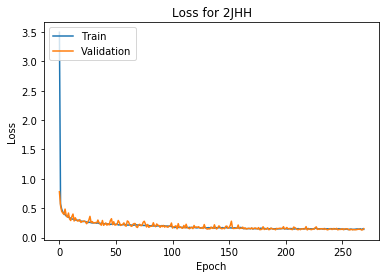

-2.0415940668304176
Training 1JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 34764 samples, validate on 8599 samples
Epoch 1/2000
34764/34764 [==============================] - 1s 26us/step - loss: 47.1240 - val_loss: 46.3167
Epoch 2/2000
34764/34764 [==============================] - 0s 11us/step - loss: 45.6202 - val_loss: 44.1651
Epoch 3/2000
34764/34764 [==============================] - 0s 10us/step - loss: 42.8313 - val_loss: 28.4776
Epoch 4/2000
34764/34764 [==============================] - 0s 11us/step - loss: 38.5410 - val_loss: 34.2446
Epoch 5/2000
34764/34764 [==============================] - 0s 11us/step - loss: 32.6799 - val_loss: 23.2136
Epoch 6/2000
34764/34764 [==============================] - 0s 11us/step - loss: 25.2076 - val_loss: 27.4405
Epoch 7/2000
34764/34764 [==============================] - 0s 10us/step - loss: 16.1297 - val_loss: 9.4616
Epoch 8/2000
34764/34764 [==============================] - 0s 11us/step - loss: 5.8986 

34764/34764 [==============================] - 0s 11us/step - loss: 0.5123 - val_loss: 0.4754
Epoch 76/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.5173 - val_loss: 0.4837
Epoch 77/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4996 - val_loss: 0.6951
Epoch 78/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.5278 - val_loss: 0.4782
Epoch 79/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4762 - val_loss: 0.4852
Epoch 80/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.5515 - val_loss: 0.4855
Epoch 81/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.5299 - val_loss: 0.4708
Epoch 82/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.5612 - val_loss: 0.5096

Epoch 00082: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 83/2000
34764/34764 [==============================] - 0s 11us/

Epoch 149/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4214 - val_loss: 0.3543
Epoch 150/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3963 - val_loss: 0.3644
Epoch 151/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3874 - val_loss: 0.3656
Epoch 152/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4368 - val_loss: 0.3727
Epoch 153/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4226 - val_loss: 0.3880
Epoch 154/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4586 - val_loss: 0.3687
Epoch 155/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4267 - val_loss: 0.3596
Epoch 156/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4567 - val_loss: 0.3575
Epoch 157/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3996 - val_loss: 0.3828
Epoch 158/2000
3476

34764/34764 [==============================] - 0s 11us/step - loss: 0.3283 - val_loss: 0.3405
Epoch 224/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3492 - val_loss: 0.3424
Epoch 225/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4077 - val_loss: 0.3321
Epoch 226/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3657 - val_loss: 0.3358
Epoch 227/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3553 - val_loss: 0.3353
Epoch 228/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3258 - val_loss: 0.3356
Epoch 229/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3909 - val_loss: 0.3676
Epoch 230/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3734 - val_loss: 0.3515
Epoch 231/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3636 - val_loss: 0.3394
Epoch 232/2000
34764/34764 [======

34764/34764 [==============================] - 0s 10us/step - loss: 0.3540 - val_loss: 0.3274
Epoch 298/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3375 - val_loss: 0.3307
Epoch 299/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3304 - val_loss: 0.3366
Epoch 300/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.2995 - val_loss: 0.3317
Epoch 301/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3367 - val_loss: 0.3273
Epoch 302/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3508 - val_loss: 0.3306
Epoch 303/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.4051 - val_loss: 0.3268

Epoch 00303: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 304/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3570 - val_loss: 0.3254
Epoch 305/2000
34764/34764 [==============================] - 

Epoch 371/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3642 - val_loss: 0.3230
Epoch 372/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3603 - val_loss: 0.3206
Epoch 373/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3400 - val_loss: 0.3208
Epoch 374/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3596 - val_loss: 0.3205
Epoch 375/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3638 - val_loss: 0.3206
Epoch 376/2000
34764/34764 [==============================] - 0s 10us/step - loss: 0.3298 - val_loss: 0.3209
Epoch 377/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3189 - val_loss: 0.3209
Epoch 378/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3438 - val_loss: 0.3196
Epoch 379/2000
34764/34764 [==============================] - 0s 11us/step - loss: 0.3715 - val_loss: 0.3219
Epoch 380/2000
3476

Epoch 00444: early stopping


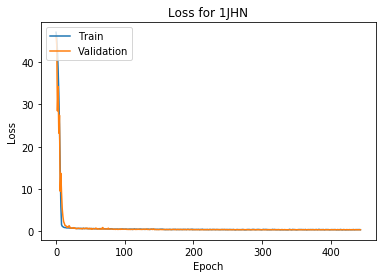

-1.1423994693074864
Training 2JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 95787 samples, validate on 23466 samples
Epoch 1/2000
95787/95787 [==============================] - 2s 17us/step - loss: 1.8666 - val_loss: 1.1945
Epoch 2/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.4893 - val_loss: 0.5993
Epoch 3/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.3794 - val_loss: 0.3640
Epoch 4/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.3439 - val_loss: 0.3827
Epoch 5/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.3211 - val_loss: 0.3137
Epoch 6/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.3059 - val_loss: 0.3271
Epoch 7/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.2841 - val_loss: 0.2566
Epoch 8/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.2818 - val_loss: 

95787/95787 [==============================] - 1s 11us/step - loss: 0.1635 - val_loss: 0.1596
Epoch 76/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1688 - val_loss: 0.1623
Epoch 77/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1562 - val_loss: 0.1511
Epoch 78/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1549 - val_loss: 0.1612
Epoch 79/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1586 - val_loss: 0.1607
Epoch 80/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1623 - val_loss: 0.1644
Epoch 81/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1625 - val_loss: 0.1565
Epoch 82/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1709 - val_loss: 0.1516
Epoch 83/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1561 - val_loss: 0.1601
Epoch 84/2000
95787/95787 [===============

95787/95787 [==============================] - 1s 11us/step - loss: 0.1518 - val_loss: 0.1800
Epoch 151/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1390 - val_loss: 0.1421
Epoch 152/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1406 - val_loss: 0.1375
Epoch 153/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1453 - val_loss: 0.1424
Epoch 154/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1563 - val_loss: 0.1622
Epoch 155/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1401 - val_loss: 0.1323
Epoch 156/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1479 - val_loss: 0.1455
Epoch 157/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1430 - val_loss: 0.1554
Epoch 158/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1444 - val_loss: 0.1376
Epoch 159/2000
95787/95787 [======

95787/95787 [==============================] - 1s 11us/step - loss: 0.1408 - val_loss: 0.1472
Epoch 226/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1339 - val_loss: 0.1298
Epoch 227/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1434 - val_loss: 0.1477
Epoch 228/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1346 - val_loss: 0.1287
Epoch 229/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1295 - val_loss: 0.1345
Epoch 230/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1356 - val_loss: 0.1476
Epoch 231/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1373 - val_loss: 0.1281
Epoch 232/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1399 - val_loss: 0.1473
Epoch 233/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1324 - val_loss: 0.1394
Epoch 234/2000
95787/95787 [======

95787/95787 [==============================] - 1s 11us/step - loss: 0.1161 - val_loss: 0.1251
Epoch 300/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1237 - val_loss: 0.1335
Epoch 301/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1228 - val_loss: 0.1192
Epoch 302/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1127 - val_loss: 0.1482
Epoch 303/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1196 - val_loss: 0.1209
Epoch 304/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1113 - val_loss: 0.1314
Epoch 305/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1231 - val_loss: 0.1153
Epoch 306/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1170 - val_loss: 0.1174
Epoch 307/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1107 - val_loss: 0.1277
Epoch 308/2000
95787/95787 [======

95787/95787 [==============================] - 1s 11us/step - loss: 0.1103 - val_loss: 0.1104
Epoch 374/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1079 - val_loss: 0.1102
Epoch 375/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1097 - val_loss: 0.1124
Epoch 376/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1157 - val_loss: 0.1111
Epoch 377/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1201 - val_loss: 0.1169
Epoch 378/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1133 - val_loss: 0.1244
Epoch 379/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1147 - val_loss: 0.1156
Epoch 380/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1069 - val_loss: 0.1135
Epoch 381/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1157 - val_loss: 0.1130
Epoch 382/2000
95787/95787 [======

Epoch 447/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.0996 - val_loss: 0.1072
Epoch 448/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1070 - val_loss: 0.1075
Epoch 449/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1028 - val_loss: 0.1078
Epoch 450/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.0964 - val_loss: 0.1075
Epoch 451/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1084 - val_loss: 0.1084
Epoch 452/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1037 - val_loss: 0.1074
Epoch 453/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1130 - val_loss: 0.1076
Epoch 454/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1007 - val_loss: 0.1075
Epoch 455/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.0943 - val_loss: 0.1075
Epoch 456/2000
9578

95787/95787 [==============================] - 1s 11us/step - loss: 0.0978 - val_loss: 0.1067
Epoch 521/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1061 - val_loss: 0.1065
Epoch 522/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1081 - val_loss: 0.1069
Epoch 523/2000
95787/95787 [==============================] - 1s 10us/step - loss: 0.1035 - val_loss: 0.1067
Epoch 524/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1002 - val_loss: 0.1064
Epoch 525/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1063 - val_loss: 0.1065
Epoch 526/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1017 - val_loss: 0.1064
Epoch 527/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1122 - val_loss: 0.1068
Epoch 528/2000
95787/95787 [==============================] - 1s 11us/step - loss: 0.1068 - val_loss: 0.1066
Epoch 529/2000
95787/95787 [======

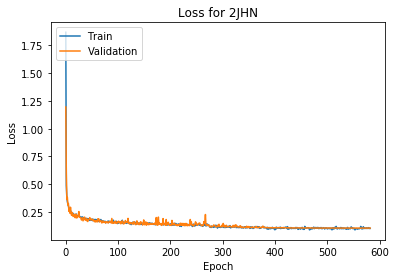

-2.241552452835503
Training 2JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 911004 samples, validate on 229670 samples
Epoch 1/2000
911004/911004 [==============================] - 11s 12us/step - loss: 0.8060 - val_loss: 0.5989
Epoch 2/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.5835 - val_loss: 0.5110
Epoch 3/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.5222 - val_loss: 0.4623
Epoch 4/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.4874 - val_loss: 0.4412
Epoch 5/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.4621 - val_loss: 0.4170
Epoch 6/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.4417 - val_loss: 0.4008
Epoch 7/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.4266 - val_loss: 0.3804
Epoch 8/2000
911004/911004 [==============================] - 10s 11us/step - 

911004/911004 [==============================] - 10s 11us/step - loss: 0.2512 - val_loss: 0.2414
Epoch 74/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2515 - val_loss: 0.2366
Epoch 75/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2519 - val_loss: 0.2409
Epoch 76/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2479 - val_loss: 0.2335
Epoch 77/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2526 - val_loss: 0.2350
Epoch 78/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2496 - val_loss: 0.2356
Epoch 79/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2500 - val_loss: 0.2290
Epoch 80/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2481 - val_loss: 0.2304
Epoch 81/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2489 - val_loss: 0.2314
Epoch 82/2000
9

911004/911004 [==============================] - 10s 11us/step - loss: 0.2285 - val_loss: 0.2128
Epoch 147/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2269 - val_loss: 0.2194
Epoch 148/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2262 - val_loss: 0.2160
Epoch 149/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2224 - val_loss: 0.2169
Epoch 150/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2267 - val_loss: 0.2157
Epoch 151/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2257 - val_loss: 0.2157
Epoch 152/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2256 - val_loss: 0.2147
Epoch 153/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2211 - val_loss: 0.2241
Epoch 154/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2257 - val_loss: 0.2101
Epoch 1

911004/911004 [==============================] - 10s 11us/step - loss: 0.2159 - val_loss: 0.2064
Epoch 220/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2171 - val_loss: 0.2043
Epoch 221/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2164 - val_loss: 0.2052
Epoch 222/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2162 - val_loss: 0.2052
Epoch 223/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2152 - val_loss: 0.2119
Epoch 224/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2144 - val_loss: 0.2043
Epoch 225/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2142 - val_loss: 0.2047
Epoch 226/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2158 - val_loss: 0.2131
Epoch 227/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2175 - val_loss: 0.2028
Epoch 2

911004/911004 [==============================] - 10s 11us/step - loss: 0.2076 - val_loss: 0.2047
Epoch 293/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2108 - val_loss: 0.2051
Epoch 294/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2107 - val_loss: 0.1992
Epoch 295/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2112 - val_loss: 0.1982
Epoch 296/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2127 - val_loss: 0.2012
Epoch 297/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2100 - val_loss: 0.1968
Epoch 298/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2082 - val_loss: 0.1994
Epoch 299/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2065 - val_loss: 0.1976
Epoch 300/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2068 - val_loss: 0.2009
Epoch 3

911004/911004 [==============================] - 10s 11us/step - loss: 0.2013 - val_loss: 0.1931
Epoch 366/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2052 - val_loss: 0.1954
Epoch 367/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2064 - val_loss: 0.1945
Epoch 368/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2065 - val_loss: 0.1934
Epoch 369/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2079 - val_loss: 0.1956
Epoch 370/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2032 - val_loss: 0.1958
Epoch 371/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2051 - val_loss: 0.2041
Epoch 372/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2015 - val_loss: 0.1958
Epoch 373/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2051 - val_loss: 0.1943
Epoch 3

911004/911004 [==============================] - 10s 11us/step - loss: 0.1974 - val_loss: 0.1931
Epoch 439/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1982 - val_loss: 0.1948
Epoch 440/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1989 - val_loss: 0.1916
Epoch 441/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2022 - val_loss: 0.2008
Epoch 442/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1979 - val_loss: 0.1921
Epoch 443/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1994 - val_loss: 0.1938
Epoch 444/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1989 - val_loss: 0.1943
Epoch 445/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2005 - val_loss: 0.1959
Epoch 446/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.2008 - val_loss: 0.1959
Epoch 4

911004/911004 [==============================] - 10s 11us/step - loss: 0.1851 - val_loss: 0.1836
Epoch 511/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1894 - val_loss: 0.1825
Epoch 512/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1906 - val_loss: 0.1835
Epoch 513/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1888 - val_loss: 0.1844
Epoch 514/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1868 - val_loss: 0.1820
Epoch 515/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1891 - val_loss: 0.1828
Epoch 516/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1861 - val_loss: 0.1828
Epoch 517/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1879 - val_loss: 0.1852
Epoch 518/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1872 - val_loss: 0.1845
Epoch 5

911004/911004 [==============================] - 10s 11us/step - loss: 0.1878 - val_loss: 0.1835
Epoch 584/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1838 - val_loss: 0.1824
Epoch 585/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1907 - val_loss: 0.1828
Epoch 586/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1886 - val_loss: 0.1836
Epoch 587/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1869 - val_loss: 0.1849
Epoch 588/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1893 - val_loss: 0.1866
Epoch 589/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1874 - val_loss: 0.1841
Epoch 590/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1869 - val_loss: 0.1814
Epoch 591/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1874 - val_loss: 0.1821
Epoch 5

911004/911004 [==============================] - 10s 11us/step - loss: 0.1833 - val_loss: 0.1792
Epoch 656/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1835 - val_loss: 0.1781
Epoch 657/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1792 - val_loss: 0.1789
Epoch 658/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1808 - val_loss: 0.1777
Epoch 659/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1797 - val_loss: 0.1797
Epoch 660/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1832 - val_loss: 0.1781
Epoch 661/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1800 - val_loss: 0.1776
Epoch 662/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1802 - val_loss: 0.1779
Epoch 663/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1811 - val_loss: 0.1778

Epoch 

Epoch 727/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1763 - val_loss: 0.1754
Epoch 728/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1783 - val_loss: 0.1754
Epoch 729/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1790 - val_loss: 0.1763
Epoch 730/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1805 - val_loss: 0.1752
Epoch 731/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1765 - val_loss: 0.1752
Epoch 732/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1792 - val_loss: 0.1750
Epoch 733/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1809 - val_loss: 0.1751
Epoch 734/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1823 - val_loss: 0.1753
Epoch 735/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1765 - val_loss:

911004/911004 [==============================] - 10s 11us/step - loss: 0.1785 - val_loss: 0.1747
Epoch 799/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1772 - val_loss: 0.1746
Epoch 800/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1766 - val_loss: 0.1748
Epoch 801/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1790 - val_loss: 0.1747
Epoch 802/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1747 - val_loss: 0.1746
Epoch 803/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1773 - val_loss: 0.1747
Epoch 804/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1775 - val_loss: 0.1747
Epoch 805/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1731 - val_loss: 0.1746
Epoch 806/2000
911004/911004 [==============================] - 10s 11us/step - loss: 0.1782 - val_loss: 0.1752
Epoch 8

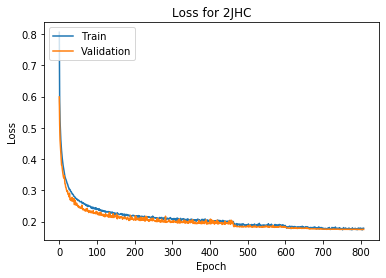

-1.7450731183483659
Training 3JHH out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 472508 samples, validate on 118103 samples
Epoch 1/2000
472508/472508 [==============================] - 6s 12us/step - loss: 1.2565 - val_loss: 0.5356
Epoch 2/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.4758 - val_loss: 0.4181
Epoch 3/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.4129 - val_loss: 0.3759
Epoch 4/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.3862 - val_loss: 0.3823
Epoch 5/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.3630 - val_loss: 0.3309
Epoch 6/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.3484 - val_loss: 0.3294
Epoch 7/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.3373 - val_loss: 0.3521
Epoch 8/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0

472508/472508 [==============================] - 5s 11us/step - loss: 0.1990 - val_loss: 0.1921
Epoch 75/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.2018 - val_loss: 0.1785
Epoch 76/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1992 - val_loss: 0.1739
Epoch 77/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.2019 - val_loss: 0.1894
Epoch 78/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1969 - val_loss: 0.1808
Epoch 79/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1986 - val_loss: 0.1801
Epoch 80/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1977 - val_loss: 0.1905
Epoch 81/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1960 - val_loss: 0.1749
Epoch 82/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1969 - val_loss: 0.1804
Epoch 83/2000
472508/472

472508/472508 [==============================] - 5s 11us/step - loss: 0.1767 - val_loss: 0.1659
Epoch 149/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1755 - val_loss: 0.1708
Epoch 150/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1812 - val_loss: 0.1613
Epoch 151/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1761 - val_loss: 0.1813
Epoch 152/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1715 - val_loss: 0.1678
Epoch 153/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1822 - val_loss: 0.1570
Epoch 154/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1812 - val_loss: 0.1640
Epoch 155/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1722 - val_loss: 0.1673
Epoch 156/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1781 - val_loss: 0.1870
Epoch 157/2000
4

Epoch 222/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1692 - val_loss: 0.1627
Epoch 223/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1647 - val_loss: 0.1512
Epoch 224/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1617 - val_loss: 0.1575
Epoch 225/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1660 - val_loss: 0.1816
Epoch 226/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1692 - val_loss: 0.1481
Epoch 227/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1617 - val_loss: 0.1582
Epoch 228/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1638 - val_loss: 0.1542
Epoch 229/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1619 - val_loss: 0.1674
Epoch 230/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1643 - val_loss: 0.1504
E

472508/472508 [==============================] - 5s 11us/step - loss: 0.1466 - val_loss: 0.1341
Epoch 296/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1488 - val_loss: 0.1361
Epoch 297/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1454 - val_loss: 0.1374
Epoch 298/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1453 - val_loss: 0.1351
Epoch 299/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1490 - val_loss: 0.1427
Epoch 300/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1478 - val_loss: 0.1381
Epoch 301/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1457 - val_loss: 0.1381
Epoch 302/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1454 - val_loss: 0.1351
Epoch 303/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1450 - val_loss: 0.1701
Epoch 304/2000
4

472508/472508 [==============================] - 5s 11us/step - loss: 0.1341 - val_loss: 0.1253
Epoch 368/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1336 - val_loss: 0.1257
Epoch 369/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1335 - val_loss: 0.1247
Epoch 370/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1357 - val_loss: 0.1278
Epoch 371/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1378 - val_loss: 0.1264
Epoch 372/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1348 - val_loss: 0.1248
Epoch 373/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1364 - val_loss: 0.1244
Epoch 374/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1306 - val_loss: 0.1260
Epoch 375/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1352 - val_loss: 0.1246
Epoch 376/2000
4

472508/472508 [==============================] - 5s 11us/step - loss: 0.1336 - val_loss: 0.1228
Epoch 441/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1311 - val_loss: 0.1235
Epoch 442/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1317 - val_loss: 0.1228
Epoch 443/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1339 - val_loss: 0.1228
Epoch 444/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1373 - val_loss: 0.1227
Epoch 445/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1346 - val_loss: 0.1230
Epoch 446/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1356 - val_loss: 0.1229
Epoch 447/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1313 - val_loss: 0.1227
Epoch 448/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1346 - val_loss: 0.1241
Epoch 449/2000
4

472508/472508 [==============================] - 5s 11us/step - loss: 0.1333 - val_loss: 0.1223
Epoch 514/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1315 - val_loss: 0.1224
Epoch 515/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1349 - val_loss: 0.1226
Epoch 516/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1309 - val_loss: 0.1229
Epoch 517/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1329 - val_loss: 0.1224
Epoch 518/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1304 - val_loss: 0.1221
Epoch 519/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1328 - val_loss: 0.1223
Epoch 520/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1340 - val_loss: 0.1225
Epoch 521/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1305 - val_loss: 0.1222
Epoch 522/2000
4

472508/472508 [==============================] - 5s 11us/step - loss: 0.1348 - val_loss: 0.1218
Epoch 586/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1364 - val_loss: 0.1218
Epoch 587/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1380 - val_loss: 0.1217
Epoch 588/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1338 - val_loss: 0.1218
Epoch 589/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1287 - val_loss: 0.1219
Epoch 590/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1322 - val_loss: 0.1218
Epoch 591/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1319 - val_loss: 0.1218
Epoch 592/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1308 - val_loss: 0.1219
Epoch 593/2000
472508/472508 [==============================] - 5s 11us/step - loss: 0.1277 - val_loss: 0.1220
Epoch 594/2000
4

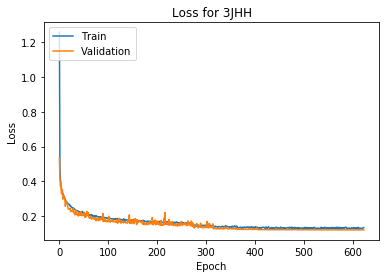

-2.1060814107301375
Training 3JHC out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 1207321 samples, validate on 303058 samples
Epoch 1/2000
1207321/1207321 [==============================] - 14s 11us/step - loss: 0.9409 - val_loss: 0.6632
Epoch 2/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.5924 - val_loss: 0.5488
Epoch 3/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.5325 - val_loss: 0.5194
Epoch 4/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.4940 - val_loss: 0.4758
Epoch 5/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.4656 - val_loss: 0.4417
Epoch 6/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.4438 - val_loss: 0.5025
Epoch 7/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.4288 - val_loss: 0.4091
Epoch 8/2000
1207321/1207321 [==============================] 

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2529 - val_loss: 0.2488
Epoch 73/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2563 - val_loss: 0.2418
Epoch 74/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2560 - val_loss: 0.2461
Epoch 75/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2538 - val_loss: 0.2514
Epoch 76/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2531 - val_loss: 0.2432
Epoch 77/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2524 - val_loss: 0.2471
Epoch 78/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2527 - val_loss: 0.2415
Epoch 79/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2500 - val_loss: 0.2410
Epoch 80/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2511 - val_loss: 0.24

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2258 - val_loss: 0.2184
Epoch 145/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2250 - val_loss: 0.2203
Epoch 146/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2240 - val_loss: 0.2177
Epoch 147/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2251 - val_loss: 0.2197
Epoch 148/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2239 - val_loss: 0.2241
Epoch 149/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2262 - val_loss: 0.2236
Epoch 150/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2240 - val_loss: 0.2205
Epoch 151/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2227 - val_loss: 0.2270
Epoch 152/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2241 - val_lo

Epoch 216/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2121 - val_loss: 0.2133
Epoch 217/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2126 - val_loss: 0.2224
Epoch 218/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2115 - val_loss: 0.2242
Epoch 219/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2111 - val_loss: 0.2097
Epoch 220/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2126 - val_loss: 0.2124
Epoch 221/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2115 - val_loss: 0.2161
Epoch 222/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2109 - val_loss: 0.2092
Epoch 223/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2108 - val_loss: 0.2082
Epoch 224/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 

Epoch 288/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2055 - val_loss: 0.2068
Epoch 289/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2051 - val_loss: 0.2057
Epoch 290/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2103 - val_loss: 0.2051
Epoch 291/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2040 - val_loss: 0.2053
Epoch 292/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2035 - val_loss: 0.2036
Epoch 293/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2048 - val_loss: 0.2089
Epoch 294/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2042 - val_loss: 0.2061
Epoch 295/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2045 - val_loss: 0.2112
Epoch 296/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 

Epoch 360/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1995 - val_loss: 0.2040
Epoch 361/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1990 - val_loss: 0.2006
Epoch 362/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1977 - val_loss: 0.2033
Epoch 363/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2006 - val_loss: 0.1997
Epoch 364/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1999 - val_loss: 0.1985
Epoch 365/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1986 - val_loss: 0.2021
Epoch 366/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1983 - val_loss: 0.1990
Epoch 367/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.2000 - val_loss: 0.1993
Epoch 368/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 

Epoch 432/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1952 - val_loss: 0.1968
Epoch 433/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1953 - val_loss: 0.1949
Epoch 434/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1939 - val_loss: 0.1997
Epoch 435/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1946 - val_loss: 0.1984
Epoch 436/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1947 - val_loss: 0.1980
Epoch 437/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1944 - val_loss: 0.1964
Epoch 438/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1935 - val_loss: 0.2102
Epoch 439/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1946 - val_loss: 0.2017
Epoch 440/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1832 - val_loss: 0.1895
Epoch 504/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1833 - val_loss: 0.1878
Epoch 505/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1810 - val_loss: 0.1876
Epoch 506/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1824 - val_loss: 0.1876
Epoch 507/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1823 - val_loss: 0.1893
Epoch 508/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1813 - val_loss: 0.1886
Epoch 509/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1831 - val_loss: 0.1860
Epoch 510/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1813 - val_loss: 0.1859
Epoch 511/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1808 - val_lo

Epoch 575/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1798 - val_loss: 0.1871
Epoch 576/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1805 - val_loss: 0.1861
Epoch 577/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1799 - val_loss: 0.1855
Epoch 578/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1800 - val_loss: 0.1854
Epoch 579/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1795 - val_loss: 0.1857
Epoch 580/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1821 - val_loss: 0.1861
Epoch 581/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1807 - val_loss: 0.1906
Epoch 582/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1812 - val_loss: 0.1874

Epoch 00582: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1722 - val_loss: 0.1822
Epoch 647/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1745 - val_loss: 0.1832

Epoch 00647: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 648/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1738 - val_loss: 0.1810
Epoch 649/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1720 - val_loss: 0.1806
Epoch 650/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1728 - val_loss: 0.1809
Epoch 651/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1717 - val_loss: 0.1804
Epoch 652/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1726 - val_loss: 0.1811
Epoch 653/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1718 - val_loss: 0.1802
Epoch 654/2000
1207321

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1705 - val_loss: 0.1794
Epoch 717/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1709 - val_loss: 0.1795
Epoch 718/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1690 - val_loss: 0.1794
Epoch 719/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1696 - val_loss: 0.1794
Epoch 720/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1705 - val_loss: 0.1795
Epoch 721/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1690 - val_loss: 0.1792
Epoch 722/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1704 - val_loss: 0.1796
Epoch 723/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1691 - val_loss: 0.1794
Epoch 724/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1691 - val_lo

1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1680 - val_loss: 0.1789
Epoch 787/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1674 - val_loss: 0.1792
Epoch 788/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1687 - val_loss: 0.1790
Epoch 789/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1696 - val_loss: 0.1787
Epoch 790/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1683 - val_loss: 0.1788
Epoch 791/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1679 - val_loss: 0.1786
Epoch 792/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1688 - val_loss: 0.1788
Epoch 793/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1693 - val_loss: 0.1789
Epoch 794/2000
1207321/1207321 [==============================] - 13s 11us/step - loss: 0.1697 - val_lo

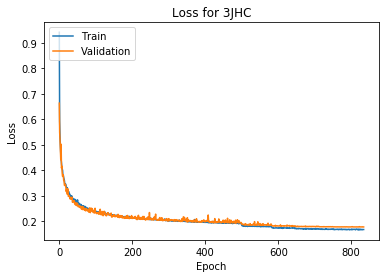

-1.7222734542428406
Training 3JHN out of ['1JHC' '2JHH' '1JHN' '2JHN' '2JHC' '3JHH' '3JHC' '3JHN'] 

Train on 133228 samples, validate on 33187 samples
Epoch 1/2000
133228/133228 [==============================] - 2s 16us/step - loss: 0.6172 - val_loss: 0.4016
Epoch 2/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.3654 - val_loss: 0.3250
Epoch 3/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.3107 - val_loss: 0.2820
Epoch 4/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.2763 - val_loss: 0.2764
Epoch 5/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.2495 - val_loss: 0.2419
Epoch 6/2000
133228/133228 [==============================] - 2s 11us/step - loss: 0.2357 - val_loss: 0.2256
Epoch 7/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.2225 - val_loss: 0.2166
Epoch 8/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.

133228/133228 [==============================] - 1s 11us/step - loss: 0.1065 - val_loss: 0.1358
Epoch 75/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1085 - val_loss: 0.1289
Epoch 76/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1043 - val_loss: 0.1273
Epoch 77/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1040 - val_loss: 0.1244
Epoch 78/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1042 - val_loss: 0.1284
Epoch 79/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1027 - val_loss: 0.1200
Epoch 80/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1004 - val_loss: 0.1228
Epoch 81/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.1009 - val_loss: 0.1240
Epoch 82/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0991 - val_loss: 0.1242
Epoch 83/2000
133228/133

133228/133228 [==============================] - 1s 11us/step - loss: 0.0855 - val_loss: 0.1125
Epoch 149/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0852 - val_loss: 0.1078
Epoch 150/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0818 - val_loss: 0.1118
Epoch 151/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0854 - val_loss: 0.1092
Epoch 152/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0836 - val_loss: 0.1083
Epoch 153/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0834 - val_loss: 0.1059
Epoch 154/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0805 - val_loss: 0.1091
Epoch 155/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0846 - val_loss: 0.1127
Epoch 156/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0836 - val_loss: 0.1120
Epoch 157/2000
1

Epoch 222/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0738 - val_loss: 0.1070
Epoch 223/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0760 - val_loss: 0.1018
Epoch 224/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0724 - val_loss: 0.1012
Epoch 225/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0783 - val_loss: 0.1040
Epoch 226/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0740 - val_loss: 0.1023
Epoch 227/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0744 - val_loss: 0.1040
Epoch 228/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0787 - val_loss: 0.1029
Epoch 229/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0754 - val_loss: 0.1010
Epoch 230/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0731 - val_loss: 0.1088
E

Epoch 296/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0711 - val_loss: 0.0989
Epoch 297/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0702 - val_loss: 0.1099
Epoch 298/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0713 - val_loss: 0.0977
Epoch 299/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0693 - val_loss: 0.0988
Epoch 300/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0687 - val_loss: 0.0985
Epoch 301/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0729 - val_loss: 0.1013
Epoch 302/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0707 - val_loss: 0.0988
Epoch 303/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0682 - val_loss: 0.1004
Epoch 304/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0690 - val_loss: 0.0994
E

133228/133228 [==============================] - 1s 11us/step - loss: 0.0602 - val_loss: 0.0948
Epoch 370/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0621 - val_loss: 0.0943
Epoch 371/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0608 - val_loss: 0.0959
Epoch 372/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0592 - val_loss: 0.0950
Epoch 373/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0592 - val_loss: 0.0943
Epoch 374/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0585 - val_loss: 0.0940
Epoch 375/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0601 - val_loss: 0.0939
Epoch 376/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0579 - val_loss: 0.0927
Epoch 377/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0586 - val_loss: 0.0939
Epoch 378/2000
1

Epoch 443/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0572 - val_loss: 0.0917
Epoch 444/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0570 - val_loss: 0.0930
Epoch 445/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0587 - val_loss: 0.0929
Epoch 446/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0580 - val_loss: 0.0934
Epoch 447/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0556 - val_loss: 0.0919
Epoch 448/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0581 - val_loss: 0.0923
Epoch 449/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0587 - val_loss: 0.0918
Epoch 450/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0568 - val_loss: 0.0975
Epoch 451/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0589 - val_loss: 0.0937
E

133228/133228 [==============================] - 1s 11us/step - loss: 0.0554 - val_loss: 0.0907
Epoch 517/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0537 - val_loss: 0.0903
Epoch 518/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0516 - val_loss: 0.0897
Epoch 519/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0525 - val_loss: 0.0905
Epoch 520/2000
133228/133228 [==============================] - 2s 11us/step - loss: 0.0542 - val_loss: 0.0904
Epoch 521/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0526 - val_loss: 0.0908
Epoch 522/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0505 - val_loss: 0.0906
Epoch 523/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0527 - val_loss: 0.0902
Epoch 524/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0545 - val_loss: 0.0898
Epoch 525/2000
1

133228/133228 [==============================] - 1s 11us/step - loss: 0.0494 - val_loss: 0.0888
Epoch 590/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0550 - val_loss: 0.0889
Epoch 591/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0505 - val_loss: 0.0887
Epoch 592/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0495 - val_loss: 0.0886
Epoch 593/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0514 - val_loss: 0.0890
Epoch 594/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0529 - val_loss: 0.0890
Epoch 595/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0510 - val_loss: 0.0889
Epoch 596/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0499 - val_loss: 0.0889
Epoch 597/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0537 - val_loss: 0.0895
Epoch 598/2000
1

133228/133228 [==============================] - 1s 11us/step - loss: 0.0517 - val_loss: 0.0887
Epoch 663/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0490 - val_loss: 0.0884
Epoch 664/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0493 - val_loss: 0.0883
Epoch 665/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0515 - val_loss: 0.0884
Epoch 666/2000
133228/133228 [==============================] - 2s 11us/step - loss: 0.0493 - val_loss: 0.0884
Epoch 667/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0492 - val_loss: 0.0885
Epoch 668/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0518 - val_loss: 0.0884
Epoch 669/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0488 - val_loss: 0.0883
Epoch 670/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0515 - val_loss: 0.0884

Epoch 00670: Re

133228/133228 [==============================] - 1s 11us/step - loss: 0.0489 - val_loss: 0.0880
Epoch 735/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0491 - val_loss: 0.0880
Epoch 736/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0478 - val_loss: 0.0880
Epoch 737/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0490 - val_loss: 0.0880

Epoch 00737: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
Epoch 738/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0479 - val_loss: 0.0879
Epoch 739/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0499 - val_loss: 0.0880
Epoch 740/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0490 - val_loss: 0.0879
Epoch 741/2000
133228/133228 [==============================] - 1s 11us/step - loss: 0.0498 - val_loss: 0.0879
Epoch 742/2000
133228/133228 [================

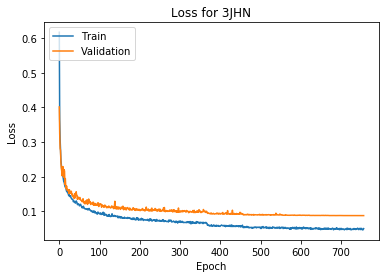

-2.430813846693948


In [19]:
# Loop through each molecule type
for mol_type in mol_types:

    #model_name_wrt = ('/kaggle/working/molecule_model_%s.hdf5' % mol_type)
    print('Training %s' % mol_type, 'out of', mol_types, '\n')

    #X_train = X_train.fillna(0)
    #X_test = X_test.fillna(0)
    # Standard Scaler from sklearn does seem to work better here than other Scalers
    input_data = FeatureTransformer().transform(
        dataset=pd.concat([X_train, X_test]),
        ohe_features=oh_cols,
        continuous_features=continuous_cols
    )
    
    #target_data = target
    
    train = input_data[:len(X_train)]
    test_input = input_data[len(X_train):]
    
    cur_type_idx_train = (train_type == mol_type)
    cur_type_idx_test = (test_type == mol_type)

    cur_type_train = train[cur_type_idx_train]
    cur_type_target = target[cur_type_idx_train]
    cur_type_mols = molecule_name[cur_type_idx_train]

    train_idx, val_idx = next(GroupShuffleSplit(random_state=42, n_splits=1, test_size=0.2).split(cur_type_train, cur_type_target, cur_type_mols))

    x_train, y_train = cur_type_train[train_idx], cur_type_target[train_idx]
    x_val, y_val = cur_type_train[val_idx], cur_type_target[val_idx]


    # Build the Neural Net
    nn_model=create_nn_model(x_train.shape[1])
    
    # If retrain==False, then we load a previous saved model as a starting point.
    if not retrain:
        nn_model = load_model(model_name_rd)
        
    nn_model.compile(loss='mae', optimizer=Adam())
    
    # Callback for Early Stopping... May want to raise the min_delta for small numbers of epochs
    es = callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=50, verbose=1, mode='auto', restore_best_weights=True)
    # Callback for Reducing the Learning Rate... when the monitor levels out for 'patience' epochs, then the LR is reduced
    rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=30, min_lr=1e-6, mode='auto', verbose=1)
    # Save the best value of the model for future use
    #sv_mod = callbacks.ModelCheckpoint(model_name_wrt, monitor='val_loss', save_best_only=True, period=1)
    history = nn_model.fit(x_train, [y_train], 
            validation_data=(x_val, [y_val]), 
            callbacks=[es, rlr], epochs=epoch_n, batch_size=batch_size, verbose=verbose)
    
    cv_predict=nn_model.predict(x_val)
    plot_history(history, mol_type)
    accuracy=np.mean(np.abs(y_val-cv_predict[:,0]))
    print(np.log(accuracy))
    cv_score.append(np.log(accuracy))
    cv_score_total+=np.log(accuracy)
    
    # Predict on the test data set using our trained model
    test_predict=nn_model.predict(test_input)
    
    # for each molecule type we'll grab the predicted values
    test_prediction[test["type"]==mol_type]=test_predict[:,0][test["type"]==mol_type]
    K.clear_session()

cv_score_total/=len(mol_types)

In [20]:
import datetime
now = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
sub = feather.read_dataframe('../data/input/sample_submission.feather')
sub['scalar_coupling_constant'] = test_prediction
sub.to_csv('../data/nn_sub_2.csv', index=False)

In [21]:
cv_score_total

-1.7561472606284803